In [1]:
import numpy as np
import ot
from scipy.sparse import coo_matrix
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import time
import psutil
import os
import gc
import tracemalloc

def get_memory_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
def test_augmented_knn(n_source=500, n_target=500, k=10, dim=2, seed=42):
    """
    Test dense vs sparse solvers on augmented KNN graph.
    
    Parameters:
    - n_source, n_target: number of points in each distribution
    - k: number of nearest neighbors for KNN graph
    - dim: dimensionality of space
    - seed: random seed
    """
    np.random.seed(seed)
    
    print(f"Test: n_source={n_source}, n_target={n_target}, k={k}, dim={dim}")
    
    X_source = np.random.randn(n_source, dim)
    X_target = np.random.randn(n_target, dim) + 0.5  # Shifted slightly
    
    a = np.ones(n_source) / n_source
    b = np.ones(n_target) / n_target
    C = cdist(X_source, X_target, metric='euclidean')
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_target)
    distances, indices = nbrs.kneighbors(X_source)
    
    rows = np.repeat(np.arange(n_source), k)
    cols = indices.flatten()
    data = distances.flatten()
    
    C_knn = coo_matrix((data, (rows, cols)), shape=(n_source, n_target))
    
    print(f"KNN graph: {C_knn.nnz:,} edges ({100*C_knn.nnz/(n_source*n_target):.2f}% density)")
    
    large_cost = 1e8
    C_dense_infty = np.full((n_source, n_target), large_cost)
    C_knn_array = C_knn.toarray()
    C_dense_infty[C_knn_array > 0] = C_knn_array[C_knn_array > 0]
    
    G_dense, log_dense = ot.emd(a, b, C_dense_infty, log=True)
    
    eps = 1e-9
    active_mask = G_dense > eps

    knn_mask = C_knn_array > 0
    extra_edges_mask = active_mask & ~knn_mask
    n_extra = extra_edges_mask.sum()
    
    if n_extra == 0:
        print("No extra edges needed.")
    else:
        print(f"Need {n_extra} extra edges beyond KNN")

    rows_aug = []
    cols_aug = []
    data_aug = []

    knn_rows, knn_cols = np.where(knn_mask)
    for i, j in zip(knn_rows, knn_cols):
        rows_aug.append(i)
        cols_aug.append(j)
        data_aug.append(C[i, j])
    
    extra_rows, extra_cols = np.where(extra_edges_mask)
    for i, j in zip(extra_rows, extra_cols):
        rows_aug.append(i)
        cols_aug.append(j)
        data_aug.append(C[i, j])
    
    C_augmented = coo_matrix((data_aug, (rows_aug, cols_aug)), shape=(n_source, n_target))
    
    C_augmented_dense = np.full((n_source, n_target), large_cost)
    C_augmented_array = C_augmented.toarray()
    C_augmented_dense[C_augmented_array > 0] = C_augmented_array[C_augmented_array > 0]

    print(f"\nAugmented graph: {C_augmented.nnz:,} edges ({100*C_augmented.nnz/(n_source*n_target):.2f}% density)")
    print(f"  = {C_knn.nnz:,} k-NN edges + {n_extra} extra edges")
    
    print(f"\nDENSE:")
    gc.collect()
    gc.collect()
    gc.collect()
    
    tracemalloc.start()
    t0 = time.perf_counter()
    G_dense_final, log_dense_final = ot.emd(a, b, C_augmented_dense, log=True)
    t_dense = time.perf_counter() - t0
    current, peak_dense = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    mem_dense = peak_dense / (1024 * 1024)
    
    cost_dense_val = log_dense_final['cost']
    warning_dense_val = log_dense_final['warning']
    
    print(f"  Cost: {cost_dense_val:.10f}")
    print(f"  Time: {t_dense*1000:.1f} ms")
    print(f"  Peak Memory: {mem_dense:.2f} MB")
    print(f"  Status: {warning_dense_val or 'OPTIMAL'}")
    
    del G_dense_final, log_dense_final, C_augmented_dense
    gc.collect()
    gc.collect()
    gc.collect()

    tracemalloc.start()
    t0 = time.perf_counter()
    G_sparse_final, log_sparse_final = ot.emd(a, b, C_augmented, log=True)
    t_sparse = time.perf_counter() - t0
    current, peak_sparse = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    mem_sparse = peak_sparse / (1024 * 1024)
    
    cost_sparse = log_sparse_final['cost']
    warning_sparse = log_sparse_final['warning']
    
    print(f"  Cost: {cost_sparse:.10f}")
    print(f"  Time: {t_sparse*1000:.1f} ms")
    print(f"  Peak Memory: {mem_sparse:.2f} MB")
    print(f"  Status: {warning_sparse or 'OPTIMAL'}")
    
    cost_diff = abs(cost_dense_val - cost_sparse)
    rel_err = cost_diff / cost_dense_val * 100 if cost_dense_val > 0 else 0
    
    if warning_dense_val is None and warning_sparse is None:
        print(f"\nCost difference: {cost_diff:.2e} ({rel_err:.6f}%)")
        
        if cost_diff < 1e-6 or rel_err < 0.01:
            print("✓ Costs match")
        else:
            print(f"⚠ Costs differ by {rel_err:.4f}%")
        
        print(f"\nPerformance:")
        print(f"  Speedup: {t_dense/t_sparse:.2f}x")
        print(f"  Memory ratio: {mem_dense/mem_sparse:.2f}x")
        print(f"  Memory saved: {mem_dense - mem_sparse:.2f} MB")
    
    return {
        'n_source': n_source,
        'n_target': n_target,
        'augmented_edges': C_augmented.nnz,
        'knn_edges': C_knn.nnz,
        'extra_edges': n_extra,
        'correct': cost_diff < 1e-6,
        'time_dense_ms': t_dense * 1000,
        'time_sparse_ms': t_sparse * 1000,
        'mem_dense_mb': mem_dense,
        'mem_sparse_mb': mem_sparse
    }


Target sparsity: 2.0% → k=2
Test: n_source=100, n_target=100, k=2, dim=2
KNN graph: 200 edges (2.00% density)
Need 40 extra edges beyond KNN

Augmented graph: 240 edges (2.40% density)
  = 200 k-NN edges + 40 extra edges

DENSE:
  Cost: 1.1810853000
  Time: 0.7 ms
  Peak Memory: 0.16 MB
  Status: OPTIMAL
  Cost: 1.1810853000
  Time: 1.4 ms
  Peak Memory: 0.02 MB
  Status: OPTIMAL

Cost difference: 4.44e-16 (0.000000%)
✓ Costs match

Performance:
  Speedup: 0.52x
  Memory ratio: 9.52x
  Memory saved: 0.14 MB
  → Actual sparsity: 2.40%
  → Speedup: 0.52x

Target sparsity: 5.0% → k=5
Test: n_source=100, n_target=100, k=5, dim=2
KNN graph: 500 edges (5.00% density)
Need 30 extra edges beyond KNN

Augmented graph: 530 edges (5.30% density)
  = 500 k-NN edges + 30 extra edges

DENSE:
  Cost: 1.1810853000
  Time: 0.7 ms
  Peak Memory: 0.16 MB
  Status: OPTIMAL
  Cost: 1.1810853000
  Time: 1.4 ms
  Peak Memory: 0.02 MB
  Status: OPTIMAL

Cost difference: 4.44e-16 (0.000000%)
✓ Costs match

Pe

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Need 1015 extra edges beyond KNN

Augmented graph: 501,015 edges (2.00% density)
  = 500,000 k-NN edges + 1015 extra edges

DENSE:

Augmented graph: 501,015 edges (2.00% density)
  = 500,000 k-NN edges + 1015 extra edges

DENSE:
  Cost: 720000.7894399854
  Time: 1414.5 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 720000.7894399854
  Time: 1414.5 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7735131107
  Time: 274.1 ms
  Peak Memory: 19.32 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 2.00%
  → Speedup: 5.16x

Target sparsity: 5.0% → k=250
Test: n_source=5000, n_target=5000, k=250, dim=2
KNN graph: 1,250,000 edges (5.00% density)
  Cost: 0.7735131107
  Time: 274.1 ms
  Peak Memory: 19.32 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 2.00%
  → Speed

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Need 706 extra edges beyond KNN

Augmented graph: 1,250,706 edges (5.00% density)
  = 1,250,000 k-NN edges + 706 extra edges

DENSE:

Augmented graph: 1,250,706 edges (5.00% density)
  = 1,250,000 k-NN edges + 706 extra edges

DENSE:
  Cost: 740000.7704406350
  Time: 1214.4 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 740000.7704406350
  Time: 1214.4 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7570805494
  Time: 469.1 ms
  Peak Memory: 47.92 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 5.00%
  → Speedup: 2.59x

Target sparsity: 10.0% → k=500
Test: n_source=5000, n_target=5000, k=500, dim=2
  Cost: 0.7570805494
  Time: 469.1 ms
  Peak Memory: 47.92 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 5.00%
  → Speedup: 2.59x

Target sparsity: 10.0% → k

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Need 352 extra edges beyond KNN

Augmented graph: 2,500,352 edges (10.00% density)
  = 2,500,000 k-NN edges + 352 extra edges

DENSE:

Augmented graph: 2,500,352 edges (10.00% density)
  = 2,500,000 k-NN edges + 352 extra edges

DENSE:
  Cost: 600000.7475545144
  Time: 1276.6 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 600000.7475545144
  Time: 1276.6 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7516682918
  Time: 1015.6 ms
  Peak Memory: 95.59 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 10.00%
  → Speedup: 1.26x

Target sparsity: 15.0% → k=750
Test: n_source=5000, n_target=5000, k=750, dim=2
  Cost: 0.7516682918
  Time: 1015.6 ms
  Peak Memory: 95.59 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 10.00%
  → Speedup: 1.26x

Target sparsity: 15.

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Need 128 extra edges beyond KNN

Augmented graph: 3,750,128 edges (15.00% density)
  = 3,750,000 k-NN edges + 128 extra edges

DENSE:

Augmented graph: 3,750,128 edges (15.00% density)
  = 3,750,000 k-NN edges + 128 extra edges

DENSE:
  Cost: 180000.7490814711
  Time: 1383.4 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 180000.7490814711
  Time: 1383.4 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.5636700331
  Time: 1598.5 ms
  Peak Memory: 143.26 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 15.00%
  → Speedup: 0.87x

Target sparsity: 20.0% → k=1000
Test: n_source=5000, n_target=5000, k=1000, dim=2
  Cost: 0.5636700331
  Time: 1598.5 ms
  Peak Memory: 143.26 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 15.00%
  → Speedup: 0.87x

Target sparsity:

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


No extra edges needed.

Augmented graph: 5,000,000 edges (20.00% density)
  = 5,000,000 k-NN edges + 0 extra edges

DENSE:

Augmented graph: 5,000,000 edges (20.00% density)
  = 5,000,000 k-NN edges + 0 extra edges

DENSE:
  Cost: 0.7420460331
  Time: 1639.3 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7420460331
  Time: 1639.3 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.6053851927
  Time: 2425.0 ms
  Peak Memory: 190.94 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 20.00%
  → Speedup: 0.68x

Target sparsity: 30.0% → k=1500
Test: n_source=5000, n_target=5000, k=1500, dim=2
  Cost: 0.6053851927
  Time: 2425.0 ms
  Peak Memory: 190.94 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 20.00%
  → Speedup: 0.68x

Target sparsity: 30.0% → k=1500
Test: n

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


No extra edges needed.

Augmented graph: 7,500,000 edges (30.00% density)
  = 7,500,000 k-NN edges + 0 extra edges

DENSE:

Augmented graph: 7,500,000 edges (30.00% density)
  = 7,500,000 k-NN edges + 0 extra edges

DENSE:
  Cost: 0.7317690179
  Time: 1581.1 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7317690179
  Time: 1581.1 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.5460762085
  Time: 4647.2 ms
  Peak Memory: 286.31 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 30.00%
  → Speedup: 0.34x

Target sparsity: 40.0% → k=2000
Test: n_source=5000, n_target=5000, k=2000, dim=2
  Cost: 0.5460762085
  Time: 4647.2 ms
  Peak Memory: 286.31 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 30.00%
  → Speedup: 0.34x

Target sparsity: 40.0% → k=2000
Test: n

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


No extra edges needed.

Augmented graph: 10,000,000 edges (40.00% density)
  = 10,000,000 k-NN edges + 0 extra edges

DENSE:

Augmented graph: 10,000,000 edges (40.00% density)
  = 10,000,000 k-NN edges + 0 extra edges

DENSE:
  Cost: 0.7307993060
  Time: 1535.9 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7307993060
  Time: 1535.9 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.5241071796
  Time: 7127.6 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 40.00%
  → Speedup: 0.22x

Target sparsity: 50.0% → k=2500
Test: n_source=5000, n_target=5000, k=2500, dim=2
  Cost: 0.5241071796
  Time: 7127.6 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 40.00%
  → Speedup: 0.22x

Target sparsity: 50.0% → k=2500
Tes

/Users/nathanneike/Desktop/HI_PARIS/POT/ot/lp/_network_simplex.py:396: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


No extra edges needed.

Augmented graph: 12,500,000 edges (50.00% density)
  = 12,500,000 k-NN edges + 0 extra edges

DENSE:

Augmented graph: 12,500,000 edges (50.00% density)
  = 12,500,000 k-NN edges + 0 extra edges

DENSE:
  Cost: 0.7305829972
  Time: 1599.9 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.7305829972
  Time: 1599.9 ms
  Peak Memory: 381.67 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  Cost: 0.5005198476
  Time: 9635.7 ms
  Peak Memory: 477.04 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 50.00%
  → Speedup: 0.17x
  Cost: 0.5005198476
  Time: 9635.7 ms
  Peak Memory: 477.04 MB
  Status: numItermax reached before optimality. Try to increase numItermax.
  → Actual sparsity: 50.00%
  → Speedup: 0.17x


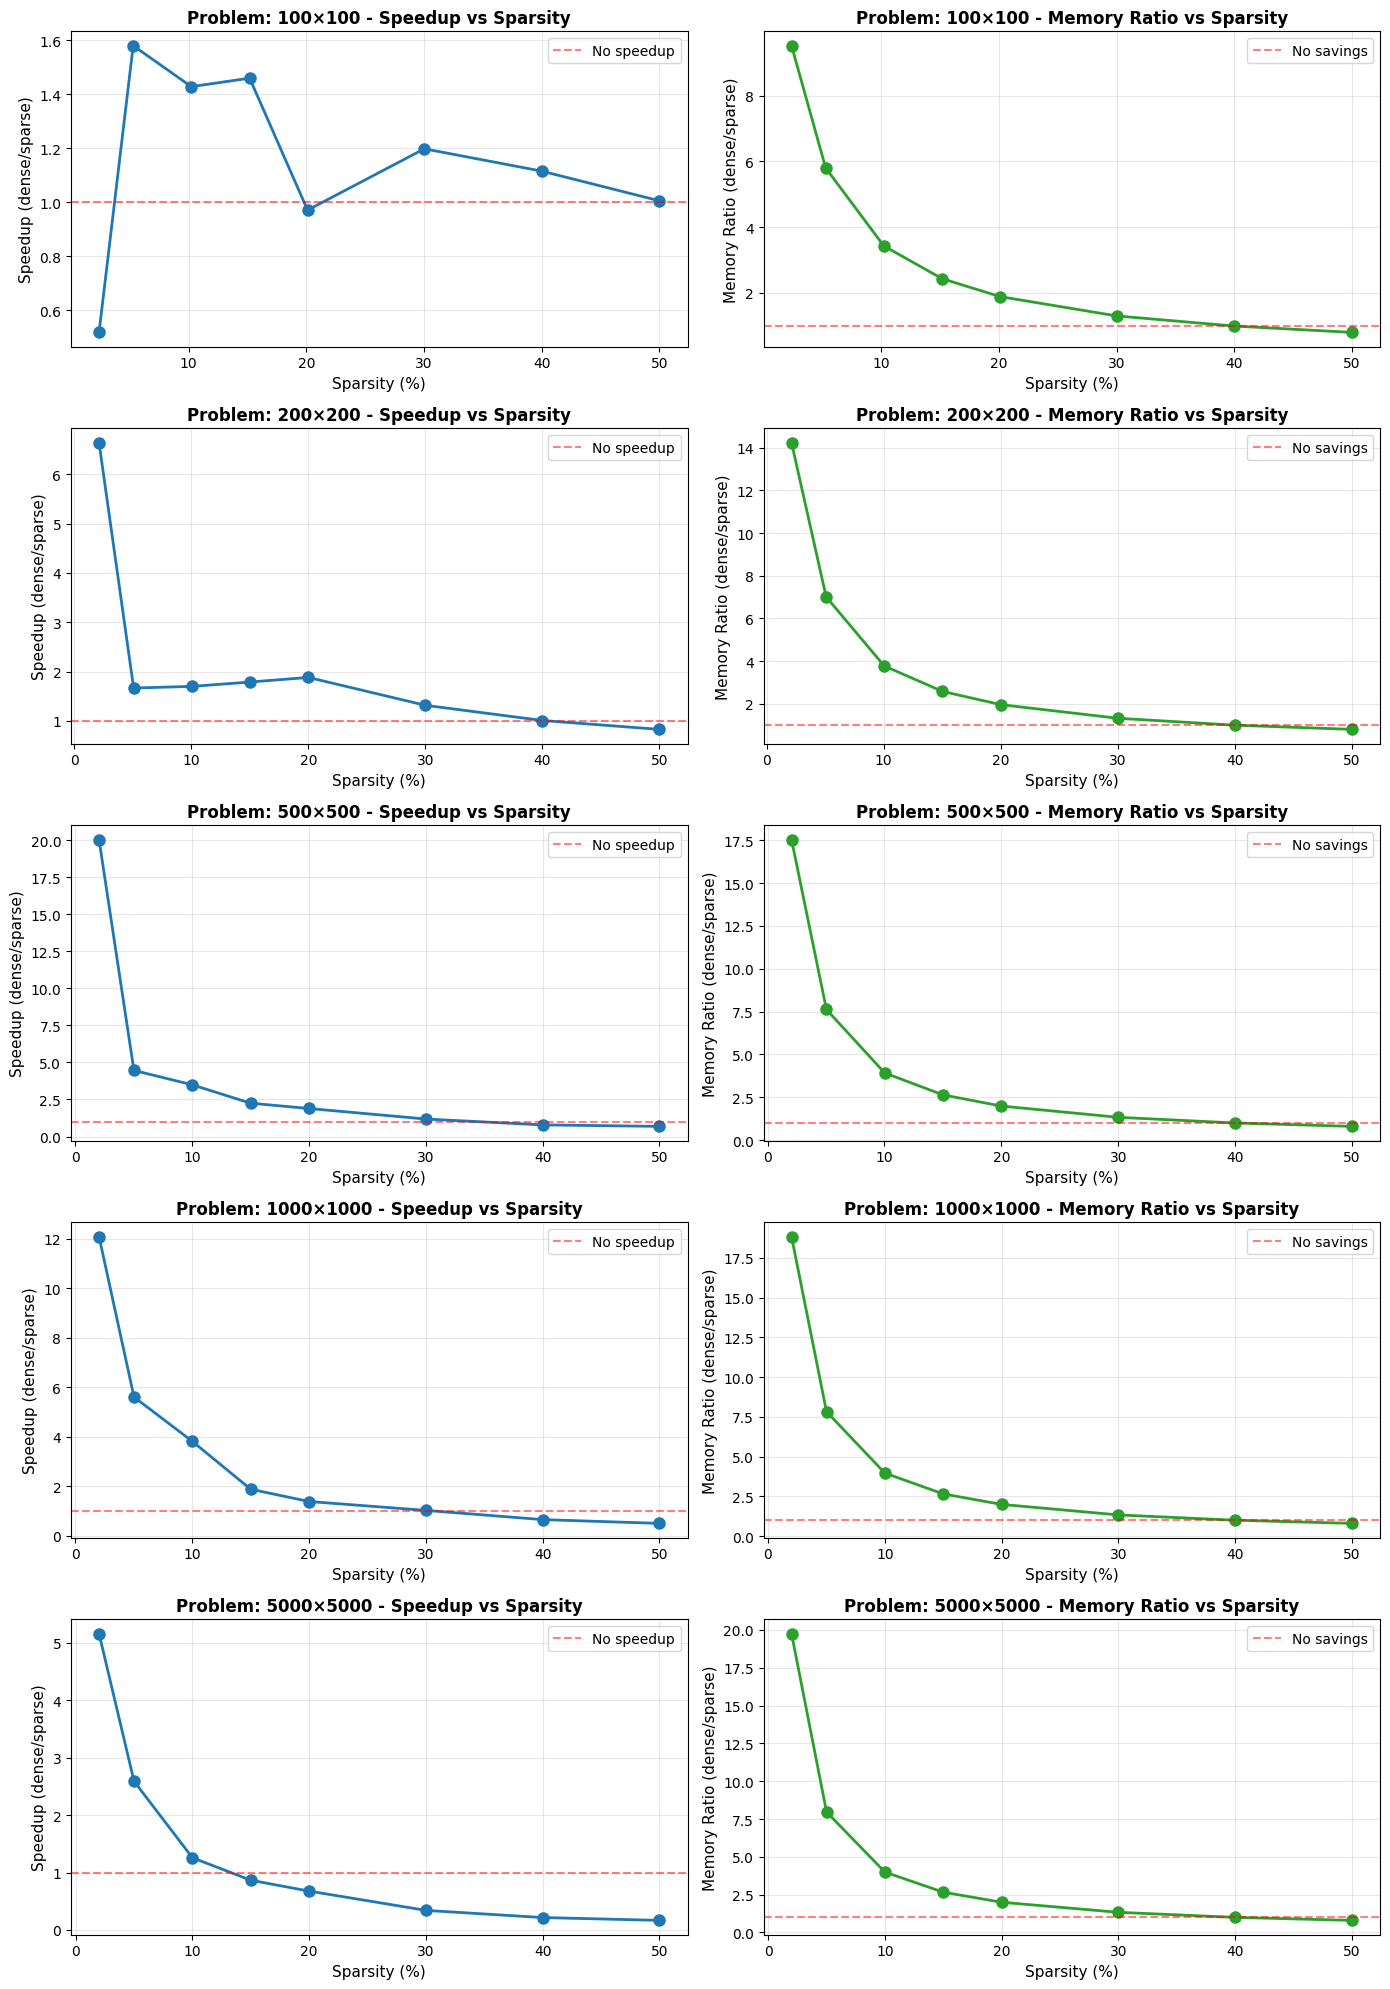

In [3]:
import matplotlib.pyplot as plt

def k_from_sparsity(n, m, target_sparsity):
    """Calculate k for unidirectional k-NN to achieve target sparsity."""

    k = int(n * m * target_sparsity / n)
    return max(1, min(k, m))  

problem_sizes = [
    (100, 100),
    (200, 200),
    (500, 500),
    (1000, 1000),
    (5000, 5000)
]

sparsity_levels = [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50]

results_by_size = {}

for n, m in problem_sizes:
    
    size_results = []
    
    for sparsity in sparsity_levels:
        k = k_from_sparsity(n, m, sparsity)
        
        print(f"\nTarget sparsity: {sparsity*100:.1f}% → k={k}")
        
        try:
            result = test_augmented_knn(n_source=n, n_target=m, k=k)
            
            actual_sparsity = result['augmented_edges'] / (n * m)
            result['target_sparsity'] = sparsity
            result['actual_sparsity'] = actual_sparsity
            result['k'] = k
            
            size_results.append(result)
            
            print(f"  → Actual sparsity: {actual_sparsity*100:.2f}%")
            print(f"  → Speedup: {result['time_dense_ms']/result['time_sparse_ms']:.2f}x")
            
        except Exception as e:
            print(f"  ✗ Failed: {e}")
    
    results_by_size[(n, m)] = size_results

n_sizes = len([k for k, v in results_by_size.items() if v])
if n_sizes > 0:
    
    fig, axes = plt.subplots(n_sizes, 2, figsize=(14, 4*n_sizes))
    if n_sizes == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ((n, m), size_results) in enumerate(results_by_size.items()):
        if not size_results:
            continue
        
        sparsities = [r['actual_sparsity'] * 100 for r in size_results]
        speedups = [r['time_dense_ms'] / r['time_sparse_ms'] for r in size_results]
        mem_ratios = [r['mem_dense_mb'] / r['mem_sparse_mb'] if r['mem_sparse_mb'] > 0 else 1 for r in size_results]
        
        axes[idx, 0].plot(sparsities, speedups, 'o-', linewidth=2, markersize=8, color='tab:blue')
        axes[idx, 0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
        axes[idx, 0].set_xlabel('Sparsity (%)', fontsize=11)
        axes[idx, 0].set_ylabel('Speedup (dense/sparse)', fontsize=11)
        axes[idx, 0].set_title(f'Problem: {n}×{m} - Speedup vs Sparsity', fontsize=12, fontweight='bold')
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].legend()
        
        axes[idx, 1].plot(sparsities, mem_ratios, 'o-', linewidth=2, markersize=8, color='tab:green')
        axes[idx, 1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No savings')
        axes[idx, 1].set_xlabel('Sparsity (%)', fontsize=11)
        axes[idx, 1].set_ylabel('Memory Ratio (dense/sparse)', fontsize=11)
        axes[idx, 1].set_title(f'Problem: {n}×{m} - Memory Ratio vs Sparsity', fontsize=12, fontweight='bold')
        axes[idx, 1].grid(True, alpha=0.3)
        axes[idx, 1].legend()
    
    plt.tight_layout()
    plt.savefig('sparsity_analysis_by_size.png', dpi=150, bbox_inches='tight')
    plt.show()